In [15]:
import skimage.io
import skimage.filters
import skimage.draw
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.signal import argrelextrema
from scipy import ndimage
%matplotlib inline

img = skimage.io.imread('../img/005.jpg')

# Binarisation de l'image
Nous allons essayer de binariser la photo du sudoku afin d'obtenir une image en noir et blanc.
Nous allons comparer deux méthodes de binarisation. Celle de Niblack et celle de Sauvola.

In [16]:
width, height, _ = img.shape

grey_img = skimage.color.rgb2gray(img.copy())

## Binarisation de Niblack

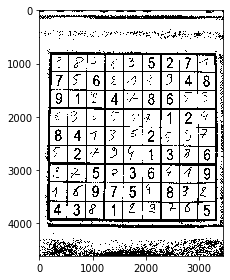

In [17]:
threshold_image = skimage.filters.threshold_niblack(grey_img, window_size=501, k=0.3)

niblack_result = np.where(grey_img < threshold_image, np.zeros((width, height)), 1)

skimage.io.imshow(niblack_result)
plt.show()

## Binarisation de Sauvola

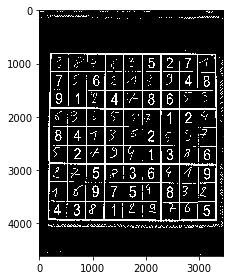

In [18]:
threshold_image = skimage.filters.threshold_sauvola(grey_img, window_size=71, k=0.1)

sauvola_result = np.where(grey_img < threshold_image, np.ones((width, height)), 0)

skimage.io.imshow(sauvola_result)
plt.show()

# Détection de la grille
## Filtrage de l'image

c:\Users\km169\Desktop\Cours\Data mining\Projet de session\sudoku-reader\env\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


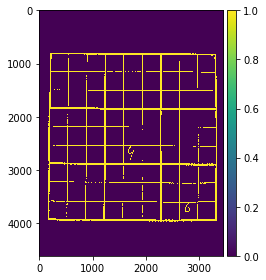

In [19]:
labeled_img, nb_labels = ndimage.label(sauvola_result)

sizes = ndimage.sum(sauvola_result, labeled_img, range(nb_labels + 1))
mask = sizes == max(sizes)

filtered_img = mask[labeled_img]
filtered_img = np.where(filtered_img == True, filtered_img, 0)
filtered_img = np.where(filtered_img == 0, filtered_img, 1)

filterted_img = ndimage.binary_dilation(filtered_img).astype(filtered_img.dtype)

skimage.io.imshow(filtered_img)

## Projections sur les différents axes

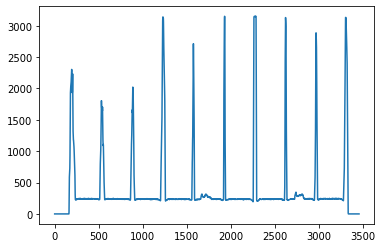

In [20]:
x_proj = filtered_img.sum(axis=0)
plt.plot(np.arange(len(x_proj)), x_proj)
plt.show()

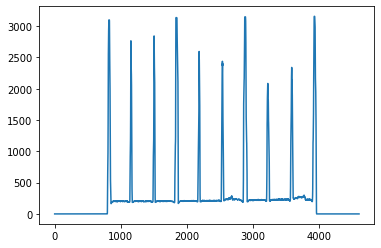

In [21]:
y_proj = filtered_img.sum(axis=1)
plt.plot(np.arange(len(y_proj)), y_proj)
plt.show()

## Reconnaissance de la grille

In [22]:
def filter_spikes(spikes):
    i = .1

    while True:

        filtered_spikes = np.array([], dtype=int)

        mean_distance = np.diff(spikes).mean()*i

        for spike in spikes:
            noise = False
            for point in filtered_spikes:
                if spike != point:
                    if abs(spike - point) < mean_distance:
                        noise = True
                        continue

            if not noise:
                filtered_spikes = np.append(filtered_spikes, spike)

        if len(filtered_spikes) <= 10:
            break

        i += .05
    
    return filtered_spikes


### Selon l'axe X

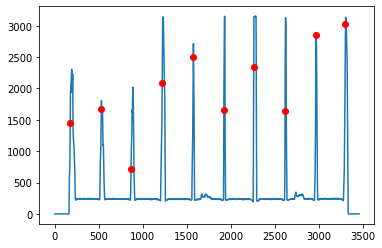

In [23]:
x_diff = np.diff(x_proj)
spikes = argrelextrema(x_diff, np.greater, order=int(len(x_diff)*.8*.05))[0] + 1
spikes = filter_spikes(spikes)


# R&cupération des x plus grand pics
highest_spikes = spikes[np.argpartition(x_proj[spikes], -min(10, len(spikes)))[-min(10, len(spikes)):]]
x_spikes = np.sort(highest_spikes)

# Affichage de la nouvelle grille
plt.plot(np.arange(len(x_proj)), x_proj)
plt.plot(x_spikes, x_proj[x_spikes], 'ro')
plt.show()

### Selon l'axe Y

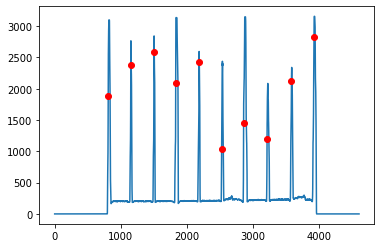

In [24]:
y_diff = np.diff(y_proj)
spikes = argrelextrema(y_diff, np.greater, order=int(len(y_diff)*.8*.05))[0] + 1
spikes = filter_spikes(spikes)


# R&cupération des x plus grand pics
highest_spikes = spikes[np.argpartition(y_proj[spikes], -min(10, len(spikes)))[-min(10, len(spikes)):]]
y_spikes = np.sort(highest_spikes)

# Affichage de la nouvelle grille
plt.plot(np.arange(len(y_proj)), y_proj)
plt.plot(y_spikes, y_proj[y_spikes], 'ro')
plt.show()

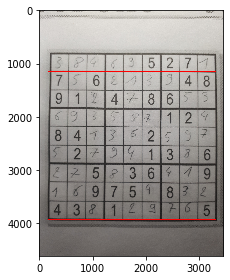

In [63]:

grid_preview = img.copy()

for i in range(len(y_spikes)):
    rr, cc = skimage.draw.line(y_spikes[i], x_spikes[0], y_spikes[i], x_spikes[-1])
    grid_preview[rr, cc] = [255, 0, 0]

for i in range(len(x_spikes)):
    rr, cc = skimage.draw.line(y_spikes[0], x_spikes[i], y_spikes[-1], x_spikes[i])
    grid_preview[rr, cc] = [255, 0, 0]

skimage.io.imshow(grid_preview)